#Model Architecture

##Xây dựng cấu trúc khối DUCK

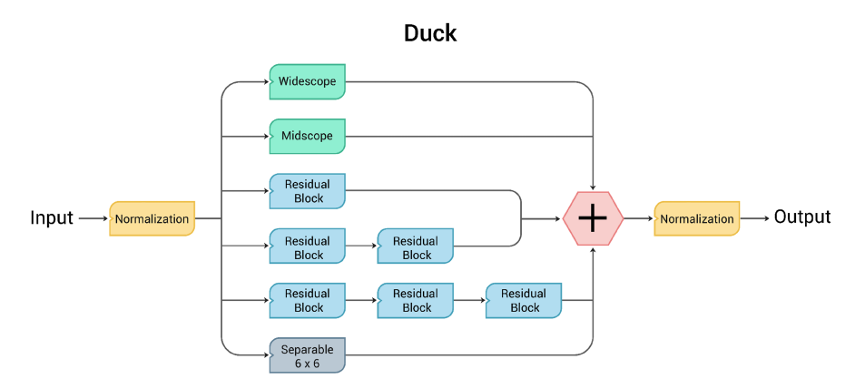
<h3> Hình 1: cấu trúc DUCK Block<h3>

In [ ]:
#File CustomLayer/ConvBlock2D.py
from tensorflow.keras.layers import BatchNormalization
from keras.layers import BatchNormalization, add
from keras.layers import Conv2D

#Khởi tạo trọng số cho cá lớp trong mạng theo phân phối đều He( phân phối đều He được thiết kế để hoạt động tốt với các hàm kích hoạt ReLU và các biến thể của nó)
kernel_initializer = 'he_uniform'


def conv_block_2D(x, filters, block_type, repeat=1, dilation_rate=1, size=3, padding='same'):
    result = x

    for i in range(0, repeat):

        if block_type == 'separated':
            result = separated_conv2D_block(result, filters, size=size, padding=padding)
        elif block_type == 'duckv2':
            result = duckv2_conv2D_block(result, filters, size=size)
        elif block_type == 'midscope':
            result = midscope_conv2D_block(result, filters)
        elif block_type == 'widescope':
            result = widescope_conv2D_block(result, filters)
        elif block_type == 'resnet':
            result = resnet_conv2D_block(result, filters, dilation_rate)
        elif block_type == 'conv':
            result = Conv2D(filters, (size, size),
                            activation='relu', kernel_initializer=kernel_initializer, padding=padding)(result)
        elif block_type == 'double_convolution':
            result = double_convolution_with_batch_normalization(result, filters, dilation_rate)

        else:
            return None

    return result

#Hình 1: Cấu Trúc DUCK Block
def duckv2_conv2D_block(x, filters, size):
    x = BatchNormalization(axis=-1)(x)
    x1 = widescope_conv2D_block(x, filters)

    x2 = midscope_conv2D_block(x, filters)
    #Lấy 1 khối Residual
    x3 = conv_block_2D(x, filters, 'resnet', repeat=1)
    #Lấy 2 khối Residual
    x4 = conv_block_2D(x, filters, 'resnet', repeat=2)
    #Lấy 3 khối Residual
    x5 = conv_block_2D(x, filters, 'resnet', repeat=3)

    x6 = separated_conv2D_block(x, filters, size=6, padding='same')

    x = add([x1, x2, x3, x4, x5, x6])

    x = BatchNormalization(axis=-1)(x)

    return x

#Cấu trúc Separable
def separated_conv2D_block(x, filters, size=3, padding='same'):
    #convolution theo chiều ngang
    x = Conv2D(filters, (1, size), activation='relu', kernel_initializer=kernel_initializer, padding=padding)(x)

    x = BatchNormalization(axis=-1)(x)
    #convolution theo chiều dọc
    x = Conv2D(filters, (size, 1), activation='relu', kernel_initializer=kernel_initializer, padding=padding)(x)

    x = BatchNormalization(axis=-1)(x)

    return x

#Cấu trúc Midscope
def midscope_conv2D_block(x, filters):
    #bộ lọc tích chập 3x3 với bước = 1
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',dilation_rate=1)(x)

    x = BatchNormalization(axis=-1)(x)
    #bộ lọc tích chập 3x3 với bước = 2
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',dilation_rate=2)(x)

    x = BatchNormalization(axis=-1)(x)

    return x

#Cấu trúc Widescope
def widescope_conv2D_block(x, filters):
    #bộ lọc tích chập 3x3 với bước = 1
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same', dilation_rate=1)(x)

    x = BatchNormalization(axis=-1)(x)
    #bộ lọc tích chập 3x3 với bước = 2
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same', dilation_rate=2)(x)

    x = BatchNormalization(axis=-1)(x)
    #bộ lọc tích chập 3x3 với bước = 3
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',dilation_rate=3)(x)

    x = BatchNormalization(axis=-1)(x)

    return x

#Cấu trúc Residual block
def resnet_conv2D_block(x, filters, dilation_rate=1):
    x1 = Conv2D(filters, (1, 1), activation='relu', kernel_initializer=kernel_initializer, padding='same',dilation_rate=dilation_rate)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)

    x_final = add([x, x1])

    x_final = BatchNormalization(axis=-1)(x_final)

    return x_final

#Cấu trúc khối tích chập kép
def double_convolution_with_batch_normalization(x, filters, dilation_rate=1):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)

    return x

##DUCK-Net


In [ ]:
import tensorflow as tf
from keras.layers import Conv2D, UpSampling2D
from keras.layers import add
from keras.models import Model

'''#Không cần thiết lấy file ConvBlock2D từ folder CustomLayers vì đang chạy trên colab và trên 1 file
from CustomLayers.ConvBlock2D import conv_block_2D'''

kernel_initializer = 'he_uniform'
interpolation = "nearest"


def create_model(img_height, img_width, input_chanels, out_classes, starting_filters):
    input_layer = tf.keras.layers.Input((img_height, img_width, input_chanels))

    print('Starting DUCK-Net')
    #Ảnh gốc thông qua bộ lọc 2(2)
    p1 = Conv2D(starting_filters * 2, 2, strides=2, padding='same')(input_layer)
    #Ảnh p1 thông qua bộ lọc 4(2^2)
    p2 = Conv2D(starting_filters * 4, 2, strides=2, padding='same')(p1)
    #Ảnh p2 thông qua bộ lọc 8(2^3)
    p3 = Conv2D(starting_filters * 8, 2, strides=2, padding='same')(p2)
    #Ảnh p3 thông qua bộ lọc 16(2^4)
    p4 = Conv2D(starting_filters * 16, 2, strides=2, padding='same')(p3)
    #Ảnh p4 thông qua bộ lọc 32(2^5)
    p5 = Conv2D(starting_filters * 32, 2, strides=2, padding='same')(p4)

    #Ảnh gốc thông qua DUCK block
    t0 = conv_block_2D(input_layer, starting_filters, 'duckv2', repeat=1)

    #Ảnh t0 thông qua bộ lọc 2
    l1i = Conv2D(starting_filters * 2, 2, strides=2, padding='same')(t0)
    #Add 2 ảnh p1 và l1i
    s1 = add([l1i, p1])
    #Ảnh s1 thông qua 1 khối DUCK
    t1 = conv_block_2D(s1, starting_filters * 2, 'duckv2', repeat=1)

    #Ảnh t1 thông qua bộ lọc 4
    l2i = Conv2D(starting_filters * 4, 2, strides=2, padding='same')(t1)
    #Add 2 ảnh p2 và l2i
    s2 = add([l2i, p2])
    #Ảnh s2 thông qua 1 khối DUCK
    t2 = conv_block_2D(s2, starting_filters * 4, 'duckv2', repeat=1)

    #Ảnh t2 thông qua bộ lọc 8
    l3i = Conv2D(starting_filters * 8, 2, strides=2, padding='same')(t2)
    #Add 2 ảnh p3 và l3i
    s3 = add([l3i, p3])
    #Ảnh s3 thông qua 1 khối DUCK
    t3 = conv_block_2D(s3, starting_filters * 8, 'duckv2', repeat=1)

    #Ảnh t3 thông qua bộ lọc 16
    l4i = Conv2D(starting_filters * 16, 2, strides=2, padding='same')(t3)
    #Add 2 ảnh p4 và l4i
    s4 = add([l4i, p4])
    #Ảnh s4 thông qua 1 khối DUCK
    t4 = conv_block_2D(s4, starting_filters * 16, 'duckv2', repeat=1)

    #Ảnh t4 thông qua bộ lọc 32
    l5i = Conv2D(starting_filters * 32, 2, strides=2, padding='same')(t4)
    #Add 2 ảnh p5 và l5i
    s5 = add([l5i, p5])
    #Ảnh s5 thông qua 2 khối residual với bộ lọc 32
    t51 = conv_block_2D(s5, starting_filters * 32, 'resnet', repeat=2)
    #Ảnh s5 thông qua 2 khối residual với bộ lọc 16
    t53 = conv_block_2D(t51, starting_filters * 16, 'resnet', repeat=2)

    #Nearest Upsampling
    l5o = UpSampling2D((2, 2), interpolation=interpolation)(t53)
    c4 = add([l5o, t4])
    q4 = conv_block_2D(c4, starting_filters * 8, 'duckv2', repeat=1)

    l4o = UpSampling2D((2, 2), interpolation=interpolation)(q4)
    c3 = add([l4o, t3])
    q3 = conv_block_2D(c3, starting_filters * 4, 'duckv2', repeat=1)

    l3o = UpSampling2D((2, 2), interpolation=interpolation)(q3)
    c2 = add([l3o, t2])
    q6 = conv_block_2D(c2, starting_filters * 2, 'duckv2', repeat=1)

    l2o = UpSampling2D((2, 2), interpolation=interpolation)(q6)
    c1 = add([l2o, t1])
    q1 = conv_block_2D(c1, starting_filters, 'duckv2', repeat=1)

    l1o = UpSampling2D((2, 2), interpolation=interpolation)(q1)
    c0 = add([l1o, t0])
    z1 = conv_block_2D(c0, starting_filters, 'duckv2', repeat=1)

    output = Conv2D(out_classes, (1, 1), activation='sigmoid')(z1)

    model = Model(inputs=input_layer, outputs=output)

    return model

##DiceLoss


In [ ]:
# import keras.backend as K
# import tensorflow as tf


# def dice_metric_loss(ground_truth, predictions, smooth=1e-6):
#     ground_truth = K.cast(ground_truth, tf.float32)
#     predictions = K.cast(predictions, tf.float32)
#     ground_truth = K.flatten(ground_truth)
#     predictions = K.flatten(predictions)
#     intersection = K.sum(predictions * ground_truth)
#     union = K.sum(predictions) + K.sum(ground_truth)
#     dice = (2. * intersection + smooth) / (union + smooth)
#     return 1 - dice


In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K  # Sử dụng tf.keras.backend thay vì keras.backend

def dice_metric_loss(ground_truth, predictions, smooth=1e-6):
    ground_truth = tf.cast(ground_truth, tf.float32)
    predictions = tf.cast(predictions, tf.float32)

    ground_truth = K.flatten(ground_truth)  # Dùng tf.keras.backend.flatten()
    predictions = K.flatten(predictions)

    intersection = K.sum(predictions * ground_truth)
    union = K.sum(predictions) + K.sum(ground_truth)

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice  # Trả về Dice loss


#Pre-Dataset


In [ ]:
# import glob

# import numpy as np
# from PIL import Image
# from skimage.io import imread
# from tqdm import tqdm

# folder_path = "/content/drive/MyDrive/Colab Notebooks/duckdataset/"  # Add the path to your data directory


# def load_data(img_height, img_width, images_to_be_loaded, dataset):
#     dataset_path = folder_path + dataset + '/'
#     IMAGES_PATH = dataset_path + 'images/'
#     MASKS_PATH = dataset_path + 'masks/'

#     if dataset == 'Kvasir-SEG':
#         train_ids = glob.glob(IMAGES_PATH + "*.jpg")

#     if dataset == 'cvc-clinicdb':
#         train_ids = glob.glob(IMAGES_PATH + "*.tif")

#     if dataset == 'cvc-colondb' or dataset == 'etis-laribpolypdb':
#         train_ids = glob.glob(IMAGES_PATH + "*.png")

#     if images_to_be_loaded == -1:
#         images_to_be_loaded = len(train_ids)

#     X_train = np.zeros((images_to_be_loaded, img_height, img_width, 3), dtype=np.float32)
#     Y_train = np.zeros((images_to_be_loaded, img_height, img_width), dtype=np.uint8)

#     print('Resizing training images and masks: ' + str(images_to_be_loaded))
#     for n, id_ in tqdm(enumerate(train_ids)):
#         if n == images_to_be_loaded:
#             break

#         image_path = id_
#         mask_path = image_path.replace("images", "masks")

#         image = imread(image_path)
#         mask_ = imread(mask_path)

#         mask = np.zeros((img_height, img_width), dtype=np.bool_)

#         pillow_image = Image.fromarray(image)

#         pillow_image = pillow_image.resize((img_height, img_width))
#         image = np.array(pillow_image)

#         X_train[n] = image / 255

#         pillow_mask = Image.fromarray(mask_)
#         pillow_mask = pillow_mask.resize((img_height, img_width), resample=Image.LANCZOS)
#         mask_ = np.array(pillow_mask)

#         for i in range(img_height):
#             for j in range(img_width):
#                 if mask_[i, j] >= 127:
#                     mask[i, j] = 1

#         Y_train[n] = mask

#     Y_train = np.expand_dims(Y_train, axis=-1)

#     return X_train, Y_train

import glob
import numpy as np
from PIL import Image
from skimage.io import imread
from tqdm import tqdm

folder_path = "/content/drive/MyDrive/Colab Notebooks/Datasets"  # Thư mục gốc chứa dataset

def load_data(img_height, img_width, dataset, split, images_to_be_loaded=-1):
    """
    Hàm tải dữ liệu hình ảnh và mask.

    Tham số:
    - img_height, img_width: Kích thước ảnh cần resize
    - dataset: Tên tập dữ liệu (ví dụ: 'Kvasir-SEG', 'CVC-ClinicDB')
    - split: 'train', 'test' hoặc 'valid'
    - images_to_be_loaded: Số lượng ảnh cần tải (-1 là tải toàn bộ)

    Trả về:
    - X: Mảng ảnh (chuẩn hóa [0,1])
    - Y: Mảng mask (nhị phân {0,1})
    """

    dataset_path = f"{folder_path}/{dataset}/{split}/"
    IMAGES_PATH = dataset_path + "images/"
    MASKS_PATH = dataset_path + "masks/"

    # Lấy danh sách ảnh theo định dạng file
    image_formats = ["*.jpg", "*.png", "*.tif"]
    train_ids = []
    for fmt in image_formats:
        train_ids.extend(glob.glob(IMAGES_PATH + fmt))

    # Giới hạn số lượng ảnh tải nếu cần
    if images_to_be_loaded == -1:
        images_to_be_loaded = len(train_ids)

    # Khởi tạo mảng đầu ra
    X = np.zeros((images_to_be_loaded, img_height, img_width, 3), dtype=np.float32)
    Y = np.zeros((images_to_be_loaded, img_height, img_width), dtype=np.uint8)

    print(f"Loading {split} dataset: {dataset} ({images_to_be_loaded} images)")
    for n, image_path in tqdm(enumerate(train_ids)):
        if n == images_to_be_loaded:
            break

        # Đường dẫn đến mask tương ứng
        mask_path = image_path.replace("images", "masks")

        # Đọc ảnh và mask
        image = imread(image_path)
        mask_ = imread(mask_path)

        # Resize ảnh
        image = np.array(Image.fromarray(image).resize((img_width, img_height)))
        mask_ = np.array(Image.fromarray(mask_).resize((img_width, img_height), resample=Image.LANCZOS))

        # Chuẩn hóa ảnh về [0,1]
        X[n] = image / 255.0

        # Chuyển mask thành nhị phân {0,1}
        mask = np.zeros((img_height, img_width), dtype=np.uint8)
        mask[mask_ >= 127] = 1
        Y[n] = mask

    # Thêm 1 chiều vào Y để phù hợp với mô hình
    Y = np.expand_dims(Y, axis=-1)

    return X, Y


#Model

In [ ]:


# Importing the necessary libraries
import os
import tensorflow as tf
import albumentations as albu
import numpy as np
import gc
import pickle
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score, f1_score
'''from ModelArchitecture.DiceLoss import dice_metric_loss
from ModelArchitecture import DUCK_Net
from ImageLoader import ImageLoader2D'''

# Checking the number of GPUs available

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Setting the model parameters

img_size = 352
dataset_type = 'Kvasir-SEG' # Options: Kvasir-SEG/CVC-ClinicDB/CVC-ColonDB/ETIS-LaribPolypDB
learning_rate = 1e-4
seed_value = 58800
filters = 17 # Number of filters, the paper presents the results with 17 and 34
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

ct = datetime.now()

model_type = "DuckNet"
# Tạo thư mục nếu chưa tồn tại
os.makedirs('ProgressFull', exist_ok=True)
os.makedirs(f'ModelSaveTensorFlow/{dataset_type}', exist_ok=True)

progress_path = 'ProgressFull/' + dataset_type + '_progress_csv_' + model_type + '_filters_' + str(filters) +  '_' + str(ct) + '.csv'
progressfull_path = 'ProgressFull/' + dataset_type + '_progress_' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.txt'
plot_path = 'ProgressFull/' + dataset_type + '_progress_plot_' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.png'
model_path = 'ModelSaveTensorFlow/' + dataset_type + '/' + model_type + '_filters_' + str(filters) + '_' + str(ct)

EPOCHS = 600
min_loss_for_saving = 0.2

Num GPUs Available:  1


In [ ]:
# # Loading the data

# X, Y = load_data(img_size, img_size, -1, 'Kvasir-SEG')


# # Splitting the data, seed for reproducibility

# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle= True, random_state = seed_value)
# x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.111, shuffle= True, random_state = seed_value)

# Tải dữ liệu từ các thư mục đã chia sẵn
x_train, y_train = load_data(img_size, img_size, 'Kvasir-SEG', 'train')
x_test, y_test = load_data(img_size, img_size, 'Kvasir-SEG', 'test')
x_valid, y_valid = load_data(img_size, img_size, 'Kvasir-SEG', 'validation')

# Kiểm tra kích thước dữ liệu
print(f"Train set: {x_train.shape}, {y_train.shape}")
print(f"Test set: {x_test.shape}, {y_test.shape}")
print(f"Validation set: {x_valid.shape}, {y_valid.shape}")


Loading train dataset: Kvasir-SEG (800 images)


800it [06:35,  2.02it/s]


Loading test dataset: Kvasir-SEG (100 images)


100it [00:45,  2.18it/s]


Loading validation dataset: Kvasir-SEG (100 images)


100it [00:47,  2.10it/s]

Train set: (800, 352, 352, 3), (800, 352, 352, 1)
Test set: (100, 352, 352, 3), (100, 352, 352, 1)
Validation set: (100, 352, 352, 3), (100, 352, 352, 1)


In [ ]:
# Defining the augmentations

aug_train = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    #always_apply=True -> p=1
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, p=1 ),
    albu.Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22), p=1),
])

def augment_images():
    x_train_out = []
    y_train_out = []

    for i in range (len(x_train)):
        ug = aug_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(ug['image'])
        y_train_out.append(ug['mask'])

    return np.array(x_train_out), np.array(y_train_out)


In [ ]:
# Creating the model

model = create_model(img_height=img_size, img_width=img_size, input_chanels=3, out_classes=1, starting_filters=filters)


Starting DUCK-Net


In [ ]:
# Compiling the model

model.compile(optimizer=optimizer, loss=dice_metric_loss)


In [ ]:
# Training the model

step = 0

for epoch in range(0, EPOCHS):

    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1

    image_augmented, mask_augmented = augment_images()

    csv_logger = CSVLogger(progress_path, append=True, separator=';')

    model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=4, validation_data=(x_valid, y_valid), verbose=1, callbacks=[csv_logger])

    prediction_valid = model.predict(x_valid, verbose=0)
    loss_valid = dice_metric_loss(y_valid, prediction_valid)

    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))

    prediction_test = model.predict(x_test, verbose=0)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))

    with open(progressfull_path, 'a') as f:
        f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\ntest_loss: ' + str(loss_test) + '\n\n\n')

    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        model.save(model_path)

    del image_augmented
    del mask_augmented

    gc.collect()


Training, epoch 0
Learning Rate: 0.0001
200/200 ━━━━━━━━━━━━━━━━━━━━ 440s 981ms/step - loss: 0.6822 - val_loss: 0.6431
Loss Validation: 0.6344111
Loss Test: 0.6185366
Training, epoch 1
Learning Rate: 0.0001
200/200 ━━━━━━━━━━━━━━━━━━━━ 171s 853ms/step - loss: 0.6014 - val_loss: 0.6033
Loss Validation: 0.5857276
Loss Test: 0.50455153
Training, epoch 2
Learning Rate: 0.0001
200/200 ━━━━━━━━━━━━━━━━━━━━ 170s 851ms/step - loss: 0.5550 - val_loss: 0.5470
Loss Validation: 0.5313068
Loss Test: 0.48241544
Training, epoch 3
Learning Rate: 0.0001
200/200 ━━━━━━━━━━━━━━━━━━━━ 171s 853ms/step - loss: 0.5489 - val_loss: 0.5181
Loss Validation: 0.5095521
Loss Test: 0.491426
Training, epoch 4
Learning Rate: 0.0001
200/200 ━━━━━━━━━━━━━━━━━━━━ 170s 852ms/step - loss: 0.5250 - val_loss: 0.4773
Loss Validation: 0.46648598
Loss Test: 0.4520054
Training, epoch 5
Learning Rate: 0.0001
200/200 ━━━━━━━━━━━━━━━━━━━━ 170s 852ms/step - loss: 0.5174 - val_loss: 0.5035
Loss Validation: 0.4917283
Loss Test: 0.4594

In [ ]:

# Computing the metrics and saving the results

print("Loading the model")

model = tf.keras.models.load_model(model_path, custom_objects={'dice_metric_loss':dice_metric_loss})

prediction_train = model.predict(x_train, batch_size=4)
prediction_valid = model.predict(x_valid, batch_size=4)
prediction_test = model.predict(x_test, batch_size=4)

print("Predictions done")

dice_train = f1_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
dice_test = f1_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
dice_valid = f1_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Dice finished")


miou_train = jaccard_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
miou_test = jaccard_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
miou_valid = jaccard_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Miou finished")


precision_train = precision_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                  np.ndarray.flatten(prediction_train > 0.5))
precision_test = precision_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                                 np.ndarray.flatten(prediction_test > 0.5))
precision_valid = precision_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                  np.ndarray.flatten(prediction_valid > 0.5))

print("Precision finished")


recall_train = recall_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                            np.ndarray.flatten(prediction_train > 0.5))
recall_test = recall_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                           np.ndarray.flatten(prediction_test > 0.5))
recall_valid = recall_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                            np.ndarray.flatten(prediction_valid > 0.5))

print("Recall finished")


accuracy_train = accuracy_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                np.ndarray.flatten(prediction_train > 0.5))
accuracy_test = accuracy_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                               np.ndarray.flatten(prediction_test > 0.5))
accuracy_valid = accuracy_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                np.ndarray.flatten(prediction_valid > 0.5))


print("Accuracy finished")


final_file = 'results_' + model_type + '_' + str(filters) + '_' + dataset_type + '.txt'
print(final_file)

with open(final_file, 'a') as f:
    f.write(dataset_type + '\n\n')
    f.write('dice_train: ' + str(dice_train) + ' dice_valid: ' + str(dice_valid) + ' dice_test: ' + str(dice_test) + '\n\n')
    f.write('miou_train: ' + str(miou_train) + ' miou_valid: ' + str(miou_valid) + ' miou_test: ' + str(miou_test) + '\n\n')
    f.write('precision_train: ' + str(precision_train) + ' precision_valid: ' + str(precision_valid) + ' precision_test: ' + str(precision_test) + '\n\n')
    f.write('recall_train: ' + str(recall_train) + ' recall_valid: ' + str(recall_valid) + ' recall_test: ' + str(recall_test) + '\n\n')
    f.write('accuracy_train: ' + str(accuracy_train) + ' accuracy_valid: ' + str(accuracy_valid) + ' accuracy_test: ' + str(accuracy_test) + '\n\n\n\n')

print('File done')

